In [1]:
from google.cloud import bigquery
import gmaps
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [2]:
# bigquery authorization
credentials = '/Users/alixh/keys/bachelor-data-analysis-service-account.json'
client = bigquery.Client.from_service_account_json(credentials)

In [3]:
# gmaps authorization for heatmap visualization
maps_api_key = ''
with open('/Users/alixh/keys/maps-api-key.txt') as f:
    maps_api_key = f.readline().strip()
    
gmaps.configure(api_key=maps_api_key)

# Contestant Location Heatmap

In [4]:
QUERY = """
SELECT hometown
FROM `bachelor-data-analysis.contestant_data.contestant_details`
"""
hometowns = client.query(QUERY).to_dataframe()

In [5]:
QUERY = """
SELECT *
FROM `bachelor-data-analysis.contestant_data.hometown_coordinates`
"""
coordinates = client.query(QUERY).to_dataframe()

In [32]:
# map coordinates to contestant hometowns
hometown_coordinates = hometowns.merge(coordinates, how='left', left_on='hometown', right_on='city')
# transform to list of tuple(latitude, longitude) for gmaps
locations = [(row.lat, row.long) for _, row in hometown_coordinates.iterrows()]

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
# Note: the image below is a static png because the interactive tool does not render in Github

<img src="map.png" alt="Contestant Location Heatmap"/>

# Winners Who Received the First Impression Rose

In [7]:
# Calculate the number of seasons that have first impression rose(s)
QUERY = """
SELECT COUNT(*) 
FROM (
    SELECT DISTINCT show, season
    FROM `bachelor-data-analysis.contestant_data.event_log`
    WHERE action = 'R1'
)
"""
seasons_w_FIR = list(client.query(QUERY))[0][0]
seasons_w_FIR

26

In [8]:
# Calculate the number of first impression rose recipients
# Note that a season may have zero to many first impression roses
QUERY = """
SELECT COUNT(*) 
FROM `bachelor-data-analysis.contestant_data.event_log`
WHERE action = 'R1'
"""
count_of_recipients = list(client.query(QUERY))[0][0]
count_of_recipients

45

In [9]:
QUERY = """
SELECT show, season, full_name 
FROM `bachelor-data-analysis.contestant_data.event_log`
WHERE contestant_id IN
(
    SELECT contestant_id
    FROM `bachelor-data-analysis.contestant_data.event_log`
    WHERE action = 'R1'
)
AND action = 'W'
"""
winners_w_FIR = client.query(QUERY).to_dataframe()
percent_of_recipients = round(len(winners_w_FIR) / count_of_recipients * 100, 2)
percent_of_seasons = round(len(winners_w_FIR) / seasons_w_FIR * 100, 2)
print("{}% of First Impression Rose recipients were winners".format(percent_of_recipients))
print("This represents {}% of seasons with First Impression Roses".format(percent_of_seasons))
winners_w_FIR

13.33% of First Impression Rose recipients were winners
This represents 23.08% of seasons with First Impression Roses


,show,season,full_name
0,Bachelor,17,Catherine Giudici
1,Bachelorette,4,Jesse Csincsak
2,Bachelorette,11,Shawn Booth
3,Bachelorette,6,Roberto Martinez
4,Bachelorette,12,Jordan Rodgers
5,Bachelorette,13,Bryan Abasolo


# Common Names

_Hypothesis: There are more people named Lauren on the Bachelor than in real life_

In [11]:
# Prepare DataFrame of top 10 Bachelor contestant first names
QUERY = """
SELECT show, REGEXP_EXTRACT(full_name, r"^[a-zA-Z.']+") AS first_name
FROM `bachelor-data-analysis.contestant_data.contestant_details`
WHERE show = 'Bachelor'
"""
bach_names = client.query(QUERY).to_dataframe()
bach_names = bach_names.groupby('first_name').size().reset_index(name='count')
bach_names['percentage'] = bach_names['count'] / bach_names['count'].sum() * 100
top_bach_names = bach_names.nlargest(10, 'percentage')[['first_name', 'percentage']]

In [12]:
# Prepare DataFrame of first names of women born between 1970 and 1995 
# (approximate contestant age range)
QUERY = """
SELECT name as first_name, SUM(number) as count
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year BETWEEN 1970 AND 1995 AND GENDER = 'F' AND name IN UNNEST(@top_names)
GROUP BY first_name
"""
top_names = list(top_bach_names.first_name)
query_param = bigquery.ArrayQueryParameter('top_names', 'STRING', top_names)
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = [query_param]
usa_names = client.query(QUERY, job_config=job_config).to_dataframe()

In [19]:
# Calcualate each name's popularity
QUERY = """
SELECT SUM(number) as total
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year BETWEEN 1970 AND 1995 AND GENDER = 'F'
"""
total_count = list(client.query(QUERY))[0].total
usa_names['percentage'] = usa_names['count'] / total_count * 100
usa_names.drop('count', axis=1, inplace=True)  # 'count' column is no longer needed

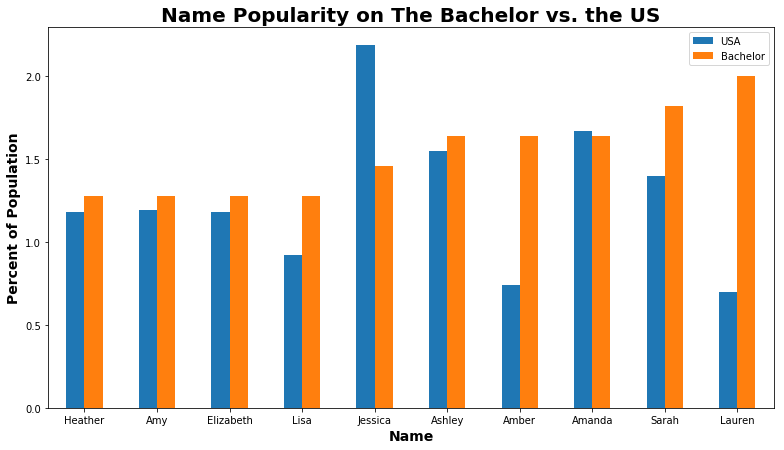

In [23]:
name_frequencies = usa_names.merge(top_bach_names, how='left', on='first_name', suffixes=['_usa','_bach'])
name_frequencies.sort_values('percentage_bach', inplace=True)

ax = name_frequencies.plot(kind='bar', x='first_name', figsize=(13,7), rot=0)
ax.legend(['USA', 'Bachelor'])
ax.set_title('Name Popularity on The Bachelor vs. the US', fontweight='bold', fontsize=20)
ax.set_ylabel('Percent of Population', fontweight='bold', fontsize=14)
ax.set_xlabel('Name', fontweight='bold', fontsize=14)
plt.show()

# Age of the Bachelor/Bachelorette Over Time

In [25]:
QUERY = """
SELECT start_date, lead_age, show
FROM `bachelor-data-analysis.contestant_data.season_details`
ORDER BY start_date
"""
lead_age_df = client.query(QUERY).to_dataframe()

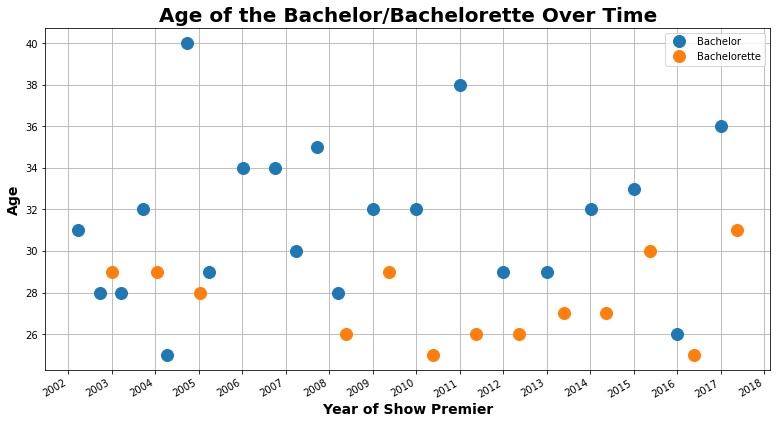

In [26]:
groups = lead_age_df.groupby('show')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot_date(group.start_date, group.lead_age, 'o', linestyle='', ms=12, label=name)
ax.legend()
    
# format the ticks
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.autoscale_view()
ax.margins(0.05)
ax.grid(True)
fig.autofmt_xdate()  # makes years diagonal

ax.set_title('Age of the Bachelor/Bachelorette Over Time', fontweight='bold', fontsize=20)
ax.set_ylabel('Age', fontweight='bold', fontsize=14)
ax.set_xlabel('Year of Show Premier', fontweight='bold', fontsize=14)
fig.set_figheight(7)
fig.set_figwidth(13)
plt.show()